In [1]:
import os
import numpy as np
import torch 
import matplotlib.pyplot as plt

import torchvision.models as models
import torch.nn as nn

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from PIL import Image
import tempfile
from monai.data import PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,  
    ToTensord,
    ScaleIntensityd,
    CenterSpatialCropd,
)
from monai.config import print_config
device = torch.device("cuda:0")
print_config()

MONAI version: 0.9.1
Numpy version: 1.20.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /home/yoonhonam/miniconda3/envs/torch/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.2
Pillow version: 8.4.0
Tensorboard version: 2.10.0a20220721
gdown version: 4.2.0
TorchVision version: 0.12.0
tqdm version: 4.61.2
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.0
transformers version: 4.15.0
mlflow version: 1.23.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Define model and load pretrained parameters

In [3]:
# transforms for inference
test_transforms = Compose(
    [
        LoadImaged(keys=["image1","image2"]),
        EnsureChannelFirstd(keys=["image1","image2"]),
        EnsureTyped(keys=["image1","image2"]),
        ScaleIntensityd(keys=["image1","image2"],minv=0.0, maxv=1.0),
        Resized(
            keys=["image1","image2"],
            spatial_size=(512,512),

        ),
        CenterSpatialCropd(keys=["image1","image2"],
                         roi_size=(448,448), 
                        ),          
        ToTensord(keys=["image1", "image2"]),
    ]
)

In [2]:
# dual-path cnn model based on EfficientNet-b7
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class Eff2_b7(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = models.efficientnet_b7(pretrained=True)
        self.b = models.efficientnet_b7(pretrained=True)
        self.a.features[0][0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.b.features[0][0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.a.classifier[1] = Identity()
        self.b.classifier[1] = Identity()
        self.c = nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(5120,2560),
            torch.nn.GELU(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(2560,1280),
            torch.nn.GELU(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(1280,2),
        )
    def forward(self, x):
        y = torch.cat((self.a(x[:,:1,:,:]),self.b(x[:,-1:,:,:])),dim=1)
        y = self.c(y)
        return y
    
model = Eff2_b7()
model.to(device)
model.load_state_dict(torch.load('model/nf_eff2_b7_v001.pth'))    

In [4]:
cutoff = 0.5
target_layers = [model.a.features[-1]]
cam1 = GradCAM(model=model, target_layers=target_layers)
target_layers = [model.b.features[-1]]
cam2 = GradCAM(model=model, target_layers=target_layers)

### Load x-ray images

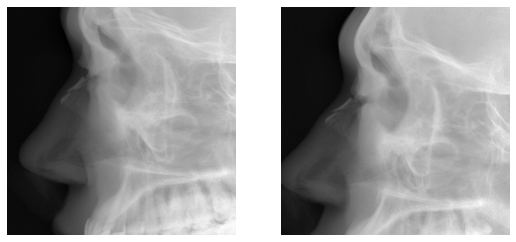

In [13]:
test_Data =[
    {
        "image1": 'image/01.png',
        "image2": 'image/02.png'    
    }
]
img = test_transforms(test_Data[0])
plt.figure(1,figsize=(9,6))
plt.subplot(121)
plt.imshow(np.transpose(img['image1'][0],(1,0)),cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.transpose(img['image2'][0],(1,0)),cmap='gray')
plt.axis('off')
plt.show()

### Test and visualize

prediction: fracture , score: 0.9999975


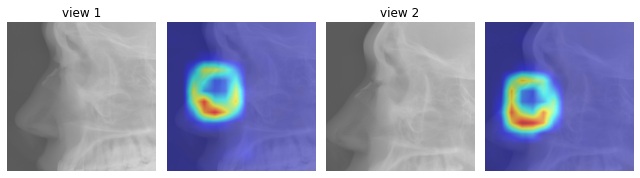

In [14]:
x1 = img['image1'].unsqueeze(0)
x2 = img['image2'].unsqueeze(0)
out1 = model(torch.cat((x1,x2),dim=1).to(device))
out2 = model(torch.cat((x2,x1),dim=1).to(device))
outp = (out1+out2).softmax(1)[:,1].cpu().detach().numpy()

if outp>cutoff:
    pred = 'fracture'
    targets = [ClassifierOutputTarget(1)]    
else:
    pred = 'normal'
    targets = [ClassifierOutputTarget(0)]    
    
print('prediction:',pred, ', score:',outp[0])

gcam1 = cam1(input_tensor=torch.cat((x1,x2),dim=1).to(device), targets=targets)
gcam2 = cam2(input_tensor=torch.cat((x2,x1),dim=1).to(device), targets=targets)
x = x1
x = torch.cat((x,x,x),dim=1)[0]
x = np.transpose(x.numpy(),(1,2,0))        
vz = show_cam_on_image(x, 1-(0.5*(gcam1[0]+gcam2[0])))

plt.figure(1,figsize=(9,6))
plt.subplot(141)
plt.imshow(np.transpose(x,(1,0,2)))
plt.axis('off')
plt.title('view 1')

plt.subplot(142)
plt.imshow(np.transpose(vz,(1,0,2)))
plt.axis('off')

gcam1 = cam2(input_tensor=torch.cat((x1,x2),dim=1).to(device), targets=targets)  
gcam2 = cam1(input_tensor=torch.cat((x2,x1),dim=1).to(device), targets=targets)    
x = x2
x = torch.cat((x,x,x),dim=1)[0]
x = np.transpose(x.numpy(),(1,2,0))        
vz = show_cam_on_image(x, 1-(0.5*(gcam1[0]+gcam2[0])))

plt.subplot(143)
plt.imshow(np.transpose(x,(1,0,2)))
plt.axis('off')
plt.title('view 2')

plt.subplot(144)
plt.imshow(np.transpose(vz,(1,0,2)))
plt.axis('off')   

plt.tight_layout()
plt.show()